baseline

-try to use just the coco set 80-20 split <br>
-check evaluation server for no-caps <br>
-load and save model to local machine <br>
-double check the model (would be useful  to get the right pipeline for eval server) <br>
- resnet(encoder state change) <br>
  - hidden state change <br>
- distribution of prediction (argmax instead of distribution)<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import pandas as pd
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import nltk
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
print(tf.__version__)
print(np.__version__)
print(nltk.__version__)
print(pd.__version__)

2.8.0
1.21.6
3.2.5
1.3.5


# get training data

## get train coco data

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 535s 0us/step


In [ ]:




if os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_file = 'annotations/captions_train2014.json'

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
train_coco_image_path_to_caption = collections.defaultdict(list)
for train in annotations['annotations']:
  caption = f"<start> {train['caption']} <end>"
  train_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (train['image_id'])
  train_coco_image_path_to_caption[train_image_path].append(caption)

In [ ]:
image_paths = list(train_coco_image_path_to_caption.keys())
random.shuffle(image_paths)

# select first 3000 images
coco_train_image_paths = image_paths[:5000]
print(len(coco_train_image_paths))

5000


In [ ]:
len(image_paths)

82783

In [ ]:
coco_train_captions = []
coco_img_name_vector = []

for image_path in coco_train_image_paths:
  caption_list = train_coco_image_path_to_caption[image_path]
  coco_train_captions.extend(caption_list)
  coco_img_name_vector.extend([image_path] * len(caption_list))

## get open images train data

In [ ]:
!cp -r /content/drive/MyDrive/open_images_data.zip /content/openimages

In [ ]:
!unzip /content/drive/MyDrive/open_images_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: OID/Dataset/train/Jacuzzi/Label/adbf12a5e32e2148.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/8321f3c8eedba6a6.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/3119879c21403c4b.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/207f06d85751d4d5.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/5faf5ea85851d362.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/085bc7bf54fcbd42.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/5366762b62d50a49.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/05ed55d9b833df9d.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/303700a13192bd34.txt  
  inflating: OID/Dataset/train/Jacuzzi/085bc7bf54fcbd42.jpg  
   creating: OID/Dataset/train/Bowl/
  inflating: OID/Dataset/train/Bowl/4d37a1f44f68ff4c.jpg  
  inflating: OID/Dataset/train/Bowl/73881309eff412ac.jpg  
  inflating: OID/Dataset/train/Bowl/0fa319ad97a353e9.jpg  
  inflating: OID/Dataset/train/Bowl/894b6209d1e9f1b6.jpg  
  

## pairing with object annotations

In [ ]:
# open csv file
csv_file_dict = "OID/csv_folder/class-descriptions-boxable.csv"
labels = pd.read_csv(csv_file_dict, names=["LabelName","Label"], header=None)
print(labels.head())

csv_file_boxes = "OID/csv_folder/train-annotations-bbox.csv"
boxes = pd.read_csv(csv_file_boxes)
print(boxes.head())

     LabelName       Label
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football
            ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938  

In [ ]:
openimages_data = boxes.merge(labels, on='LabelName', how='inner')

In [ ]:
# get image ids
import glob
import os
my_path = "OID/Dataset/train"
files = glob.glob(my_path + '/**/*.jpg', recursive=True)
filenames = [os.path.splitext(os.path.basename(file))[0] for file in files]
print(len(filenames))
filenames[0:20]

4311


['78413b206ebf0b65',
 '67150a03bbb04c30',
 '879559531569673b',
 '0fda79db717300b8',
 '2bdab1c91c26130b',
 'd65ac61c5d92a064',
 '94b5b44c1baff08c',
 'bdf791f94c711ed9',
 '65ab73b98da93a13',
 '9b72387f0e8380d6',
 '8ee4b61f109a17f8',
 'a442855a98de7bfd',
 '0136feb857f1e0cc',
 '47f8b5c213d1a76c',
 '85cac76a57a7ca10',
 '86f95723f5c961e0',
 '3ea64cc4f6bf12f0',
 '72293c41628cd566',
 '42b208bd228b0754',
 '796499c179e496e3']

In [ ]:
data_filtered = openimages_data[openimages_data['ImageID'].isin(filenames)]

In [ ]:
# print(len(openimages_data))
# print(len(data_filtered))
# data_filtered.head(-1)

In [ ]:
test = data_filtered.groupby('ImageID')

In [ ]:
test.groups

{'00010417d07870a7': [3424314, 3424315, 3424316, 5880599, 5880600, 5880601, 5880602, 5880603, 5880604, 9034112, 9034113, 9034114, 9034115, 10265763, 10265764, 10265765, 10265766, 10441000, 10466984, 10466985, 10538445, 10538446, 12637045, 12637046, 12746089, 12746090, 12746091, 12746092, 12746093, 12746094, 12746095, 13453037], '000a5fa54328fad5': [13622499, 14383748], '000e70d6b9f25c3d': [9028050, 11549647, 12298649, 12499647, 12499648, 14283143, 14314616, 14314617, 14314618, 14314619, 14314620, 14328071, 14404053, 14404054, 14404055, 14419207, 14429723], '000f186681cac78d': [1140408, 3425008, 6089661, 12440152], '001141ea46dec113': [11754520, 11754521], '0015628e66861c6e': [2919234, 6089694, 10710758, 12637118, 12637119, 13613941, 14076902], '00168fd1b1eeab88': [6345546], '001b8eac86d79744': [11281762, 11281763, 13402388, 13404465], '001bb3020830f63b': [12718933, 13046738, 13491594, 13590910, 13792500, 14407954], '001e61db0f5130d9': [14509761, 14509849], '002150b620f2aa6d': [11699597

In [ ]:
test.groups

{'00010417d07870a7': [3424314, 3424315, 3424316, 5880599, 5880600, 5880601, 5880602, 5880603, 5880604, 9034112, 9034113, 9034114, 9034115, 10265763, 10265764, 10265765, 10265766, 10441000, 10466984, 10466985, 10538445, 10538446, 12637045, 12637046, 12746089, 12746090, 12746091, 12746092, 12746093, 12746094, 12746095, 13453037], '000a5fa54328fad5': [13622499, 14383748], '000e70d6b9f25c3d': [9028050, 11549647, 12298649, 12499647, 12499648, 14283143, 14314616, 14314617, 14314618, 14314619, 14314620, 14328071, 14404053, 14404054, 14404055, 14419207, 14429723], '000f186681cac78d': [1140408, 3425008, 6089661, 12440152], '001141ea46dec113': [11754520, 11754521], '0015628e66861c6e': [2919234, 6089694, 10710758, 12637118, 12637119, 13613941, 14076902], '00168fd1b1eeab88': [6345546], '001b8eac86d79744': [11281762, 11281763, 13402388, 13404465], '001bb3020830f63b': [12718933, 13046738, 13491594, 13590910, 13792500, 14407954], '001e61db0f5130d9': [14509761, 14509849], '002150b620f2aa6d': [11699597

In [ ]:
indexes = list(test.groups['00010417d07870a7'])

In [ ]:
# openimages_data.iloc[[11754520, 11754521]]["Label"]

In [ ]:
openimages_data[openimages_data['ImageID'].isin(['56c713d0527a6b07'])]

ImageID  Source  LabelName  Confidence      XMin      XMax  \
1202000   56c713d0527a6b07  xclick   /m/0cgh4           1  0.000000  0.410000   
1202001   56c713d0527a6b07  xclick   /m/0cgh4           1  0.403333  0.999167   
1202002   56c713d0527a6b07  xclick   /m/0cgh4           1  0.968333  0.999167   
1494275   56c713d0527a6b07  xclick   /m/0d4v4           1  0.120000  0.165000   
1494276   56c713d0527a6b07  xclick   /m/0d4v4           1  0.130833  0.195000   
1494277   56c713d0527a6b07  xclick   /m/0d4v4           1  0.213333  0.276667   
1494278   56c713d0527a6b07  xclick   /m/0d4v4           1  0.310833  0.356667   
1494279   56c713d0527a6b07  xclick   /m/0d4v4           1  0.363333  0.400000   
1494280   56c713d0527a6b07  xclick   /m/0d4v4           1  0.372500  0.385833   
1494281   56c713d0527a6b07  xclick   /m/0d4v4           1  0.376667  0.404167   
11373120  56c713d0527a6b07  xclick   /m/05s2s           1  0.000000  0.431667   
14100038  56c713d0527a6b07  xclick  /m/01lynh           1  0.423333  0.797500   

              YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
1202000   0.000000  0.690625           1            1          0            0   
1202001   0.263750  0.904375           1            1          0            0   
1202002   0.495625  0.535000           1            1          0            0   
1494275   0.080625  0.241250           0            0          0            0   
1494276   0.000000  0.079375           0            0          0            0   
1494277   0.278750  0.385000           0            0          0            0   
1494278   0.313125  0.408750           0            0          0            0   
1494279   0.053750  0.135625           0            0          0            0   
1494280   0.138750  0.214375           0            0          0            0   
1494281   0.350625  0.434375           0            0          0            0   
11373120  0.843125  0.944375           1            1          1            0   
14100038  0.414375  0.937500           0            0          1            0   

          IsInside     Label  
1202000          0  Building  
1202001          0  Building  
1202002          0  Building  
1494275          0    Window  
1494276          0    Window  
1494277          0    Window  
1494278          0    Window  
1494279          0    Window  
1494280          0    Window  
1494281          0    Window  
11373120         0     Plant  
14100038         0    Stairs

In [ ]:
open_image_caption = []
open_image_img_name_vector = []
for afile in files:
  print(afile)
  key = os.path.splitext(os.path.basename(afile))[0]
  print(key)
  values = test.groups[key]
  series = openimages_data.iloc[values]["Label"]
  string = " ".join(list(series))
  print(string)
  open_image_caption.append(string)
  open_image_img_name_vector.append(afile)
  print("---------------------------------------")

Streaming output truncated to the last 5000 lines.
OID/Dataset/train/Deer/b6cac32b4a8a2d57.jpg
b6cac32b4a8a2d57
Tree Tree Tree Tree Tree Tree Tree Deer
---------------------------------------
OID/Dataset/train/Deer/33b5ee5a7882af20.jpg
33b5ee5a7882af20
Deer
---------------------------------------
OID/Dataset/train/Deer/7a9bf6d989a2c8b8.jpg
7a9bf6d989a2c8b8
Deer Deer
---------------------------------------
OID/Dataset/train/Deer/7d1c48e9ea2164f0.jpg
7d1c48e9ea2164f0
Tree Tree Tree Tree Deer
---------------------------------------
OID/Dataset/train/Deer/2b10d7e22ff295e5.jpg
2b10d7e22ff295e5
Deer
---------------------------------------
OID/Dataset/train/Deer/2697127de3af2992.jpg
2697127de3af2992
Tree Tree Tree Tree Tree Tree Deer Deer Deer Deer Antelope Antelope Antelope Antelope
---------------------------------------
OID/Dataset/train/Deer/02eea09961a5315b.jpg
02eea09961a5315b
Plant Plant Plant Deer Antelope
---------------------------------------
OID/Dataset/train/Deer/680d31183379841a

Ratchet Ratchet Chisel


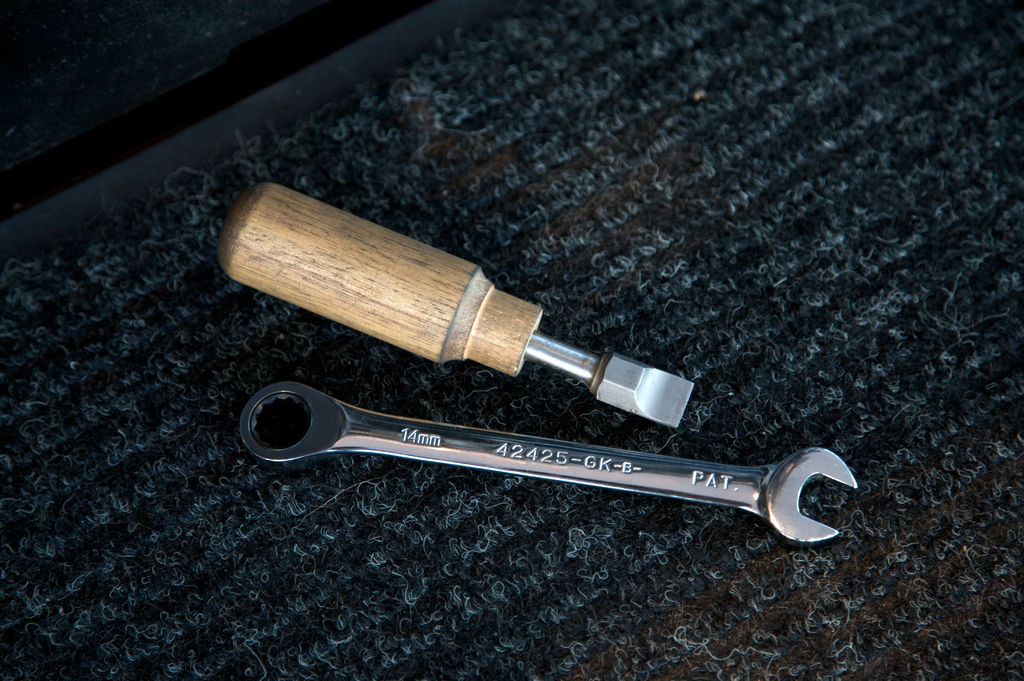

In [ ]:
# get open_images example
idx = 1991
open_image = open_image_img_name_vector[idx]
open_caption = open_image_caption[idx]
print(open_caption)
picture = Image.open(open_image)
display(picture)

In [ ]:
test.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
4401      009297f8736202bb  xclick  /m/01g317           1  0.236250  0.821875   
5519      00da1b7489729584  xclick  /m/01g317           1  0.465625  0.485938   
5520      00da1b7489729584  xclick  /m/01g317           1  0.478906  0.522656   
5521      00da1b7489729584  xclick  /m/01g317           1  0.489062  0.516406   
5522      00da1b7489729584  xclick  /m/01g317           1  0.502344  0.551562   
...                    ...     ...        ...         ...       ...       ...   
14610153  b923638925498036  xclick   /m/0km7z           1  0.267500  0.999375   
14610155  e0187e1e48d7d6e5  xclick   /m/0km7z           1  0.000000  0.481250   
14610156  e0187e1e48d7d6e5  xclick   /m/0km7z           1  0.000000  0.486875   
14610157  e0187e1e48d7d6e5  xclick   /m/0km7z           1  0.000000  0.790000   
14610158  e0187e1e48d7d6e5  xclick   /m/0km7z           1  0.000000  0.800625   

              YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
4401      0.050000  0.999167           1            1          0            0   
5519      0.435417  0.500000           1            0          0            0   
5520      0.339583  0.425000           0            0          0            0   
5521      0.345833  0.397917           1            0          0            0   
5522      0.323958  0.425000           0            0          0            0   
...            ...       ...         ...          ...        ...          ...   
14610153  0.180621  0.846660           1            1          0            0   
14610155  0.430833  0.965833           1            1          0            0   
14610156  0.394167  0.969167           1            1          0            0   
14610157  0.000000  0.952500           1            1          0            0   
14610158  0.000000  0.965833           1            1          0            0   

          IsInside   Label  
4401             0  Person  
5519             0  Person  
5520             0  Person  
5521             0  Person  
5522             0  Person  
...            ...     ...  
14610153         0   Skunk  
14610155         0   Skunk  
14610156         0   Skunk  
14610157         0   Skunk  
14610158         0   Skunk  

[11122 rows x 14 columns]

In [ ]:
# # the glob data has the filenames 
# # for each filename, 
# imageids = filenames #.unique()

# dictionary = {}
# for image_id in imageids:
#   subset = data_filtered.loc[data_filtered['ImageID'] == image_id]
#   labels_list = list(subset["Label"])
#   labels_list.append("<end>")
#   labels_list.insert(0,"<start>")
#   labels_str = " ".join(labels_list)
#   dictionary[id] = labels_str


In [ ]:
# openimages_data[openimages_data['ImageID'].isin(['0a7a9e434ba275e3'])]

In [ ]:
# Image.open('OID/Dataset/train/Fireplace/47f8b5c213d1a76c.jpg')

In [ ]:
# for image ids filter images in dataframe
# data_filtered = openimages_data[openimages_data['ImageID'].isin(filenames)]

In [ ]:
# data_filtered.head()

In [ ]:
# len(data_filtered)

In [ ]:
# # make string out of object labels.
# imageids = data_filtered['ImageID'] #.unique()
# len(imageids)
# dictionary = {}
# for id in imageids:
#   subset = openimages_data[openimages_data['ImageID'].isin([id])]
#   labels_list = list(subset["Label"])
#   labels_list.append("<end>")
#   labels_list.insert(0,"<start>")
#   labels_str = " ".join(labels_list)
#   dictionary[id] = labels_str

In [ ]:
# imageids[0]

In [ ]:
# idx = 1
# openimages_data[openimages_data['ImageID'].isin([imageids[idx]])]

## combine coco and open images data

In [ ]:
# get captions
#open_images_object_string = list(dictionary.values())
data_train_captions = coco_train_captions + open_image_caption

In [ ]:
# get images
# open_image_img_name_vector = []
# for image_path in files:
#   open_image_img_name_vector.extend([image_path])

data_train_images = coco_img_name_vector + open_image_img_name_vector

In [ ]:
print(len(open_image_img_name_vector))
print(len(open_image_caption))

4311
4311


In [ ]:
print(len(coco_train_captions))
print(len(coco_img_name_vector))

25008
25008


### display image

<start> A group of young men riding skateboards down a small road. <end>


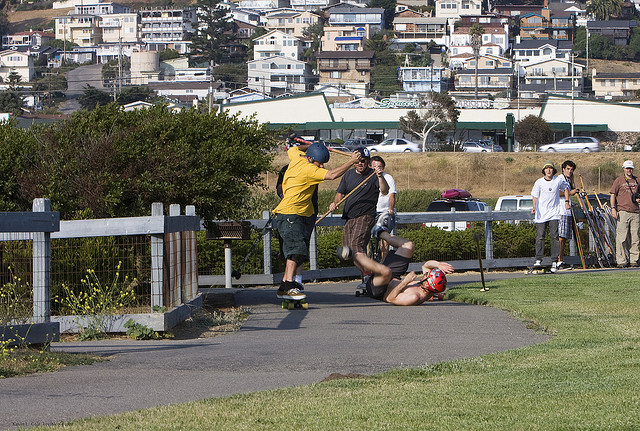

In [ ]:
# get coco example
idx = 10
caption = coco_train_captions[idx]
image = coco_img_name_vector[idx]
print(caption)
picture = Image.open(image)
picture

Curtain Curtain Curtain Curtain Bed


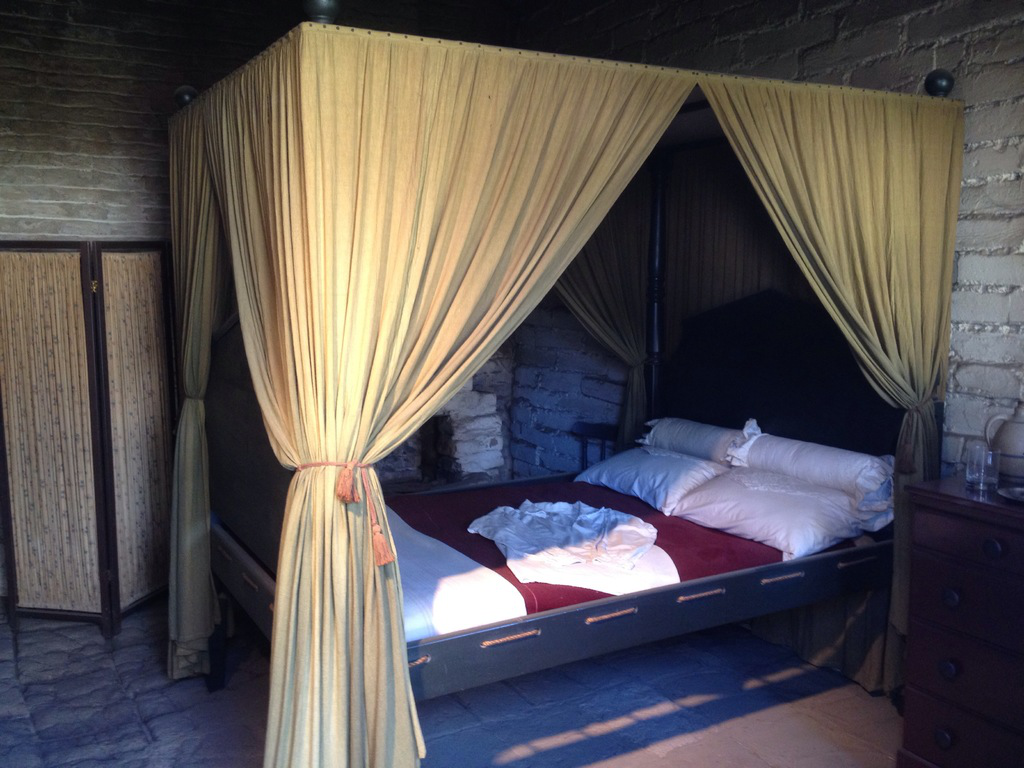

In [ ]:
# get open_images example
idx = 19
open_image = open_image_img_name_vector[idx]
open_caption = open_image_caption[idx]
print(open_caption)
picture = Image.open(open_image)
picture

In [ ]:
# # get coco example
# idx_list = [10,11,12,13,14]
# for idx in idx_list:
#   caption = coco_train_captions[idx]
#   image = coco_img_name_vector[idx]
#   print(caption)
#   picture = Image.open(image)
#   #display(picture)

# get validation data

In [ ]:
# get open images validation images
!wget https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json

--2022-04-26 19:31:28--  https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.86.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.86.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1101959 (1.1M) [application/json]
Saving to: ‘nocaps_val_image_info.json’

nocaps_val_image_in 100%[===================>]   1.05M  3.39MB/s    in 0.3s    

2022-04-26 19:31:28 (3.39 MB/s) - ‘nocaps_val_image_info.json’ saved [1101959/1101959]



In [ ]:
# open json
import json
validation_open_images = "nocaps_val_image_info.json"
f1 = open(validation_open_images)
validation_open_images = json.load(f1)
f1.close()

In [ ]:
validation_open_images["images"][0]

{'coco_url': 'https://s3.amazonaws.com/nocaps/val/0013ea2087020901.jpg',
 'date_captured': '2018-11-06 11:04:33',
 'file_name': '0013ea2087020901.jpg',
 'height': 1024,
 'id': 0,
 'license': 0,
 'open_images_id': '0013ea2087020901',
 'width': 732}

In [ ]:
# from PIL import Image
# import requests

# for image in validation_open_images["images"][0:5]:
#   im = Image.open(requests.get(image['coco_url'], stream=True).raw)
#   #display(im)

## get coco validation data

In [ ]:
# Download image files
image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6645022720/6645013297 [==============================] - 154s 0us/step


In [ ]:
if os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_file = 'annotations/captions_val2014.json'

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
train_coco_image_path_to_caption = collections.defaultdict(list)
for train in annotations['annotations']:
  caption = f"<start> {train['caption']} <end>"
  train_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (train['image_id'])
  train_coco_image_path_to_caption[train_image_path].append(caption)

## get open images validation data

In [ ]:
# get open images validation captions
!wget https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json

--2022-04-26 19:36:09--  https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.9.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.9.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1101959 (1.1M) [application/json]
Saving to: ‘nocaps_val_image_info.json.1’

nocaps_val_image_in 100%[===================>]   1.05M   779KB/s    in 1.4s    

2022-04-26 19:36:10 (779 KB/s) - ‘nocaps_val_image_info.json.1’ saved [1101959/1101959]



# get test data

## get coco test data

## get open images test data

In [ ]:
# get open images test captions
!wget https://s3.amazonaws.com/nocaps/nocaps_test_image_info.json

--2022-04-26 19:36:11--  https://s3.amazonaws.com/nocaps/nocaps_test_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.9.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.9.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2613626 (2.5M) [application/json]
Saving to: ‘nocaps_test_image_info.json’

nocaps_test_image_i 100%[===================>]   2.49M  1.54MB/s    in 1.6s    

2022-04-26 19:36:13 (1.54 MB/s) - ‘nocaps_test_image_info.json’ saved [2613626/2613626]



# data preprocess

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
image_model = tf.keras.applications.resnet.ResNet152(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

234708992/234698864 [==============================] - 4s 0us/step


In [ ]:
# Get unique images
encode_train = sorted(set(data_train_images))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(data_train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(data_train_images, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(23436, 23436, 5883, 5883)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 256
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
# attention_features_shape = 64
attention_features_shape = 100

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1) 
    #print("hidden shape: ", hidden.shape) # (64, 256)

    # attention_hidden_layer shape == (batch_size, 64, units)
    #print("vector shapes: ", features.shape, hidden_with_time_axis.shape) #(64, 64, 256) (64, 1, 256)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

    # K = self.W1(features)
    # Q = self.W2(hidden_with_time_axis)
    # #print("K and Q shape: ", K.shape, Q.shape, features.shape, hidden_with_time_axis.shape)
    # attention_hidden_layer = tf.linalg.matmul(K, Q, transpose_b=True)

    #print("attention_hidden_layer dim:",attention_hidden_layer) # (64, 64, 256)

    #tf.tensordot(features,hidden_with_time_axis,axes = 0) 
    #print("attention_hidden_layer dim: ", attention_hidden_layer.shape)
    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer) # (64, 64, 1)
    #print("score dim:", score.shape)
    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context_vector dim:", context_vector.shape)
    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        #print("encode fc dim:", x)

        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    #print("input dim x, features, hidden:", x.shape, features.shape, hidden.shape)
    # defining attention as a separate model
    #print("x shape:",x.shape) # (64, 1)
    #x = self.embedding(x)
    #print("x shape:",x.shape) # (64, 1, 256)
    #_, state = self.gru(x)
    #print("shape test:",x.shape,hidden.shape, state.shape,features.shape) # (64, 1, 256) (64, 256) (64, 256) (64, 64, 256)

    context_vector, attention_weights = self.attention(features, hidden)

    #print("context vector dim: ", context_vector.shape)
    #print("attention weights dim: ", attention_weights.shape)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    #print("embedding dim:", x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    #print("concat dim:", x)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    #print("gru dim:", output)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    #print("decode fc1 dim:", x)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    #print("decode fc2 dim:", x)


    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
import keras.backend as K
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  #print("loss shapes:", real.shape,pred.shape,mask.shape)
  #print("values:", tf.print(pred))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

# training

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  #print("hidden shape: ", hidden.shape)
  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
  #print("dec input: ",dec_input.shape)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      print("features shape:",features.shape)


      for i in range(1, target.shape[1]):
          #print("target one:",target.shape[1])
          #print("test i:", i)
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          #print("target shape: ",target[:,i].shape) (64,)
          #print("pred shape: ",predictions.shape) (64,5000)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        #print("image shape, caption shape:",img_tensor.shape, target.shape)
        #print("target:",target)
        #print("target:",target[0])
        batch_loss, t_loss = train_step(img_tensor, target)
        
        #print("--------------------------------")
        total_loss += t_loss

        if batch % 10 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    #print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    #print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

features shape: (64, 100, 256)
features shape: (64, 100, 256)
Epoch 1 Batch 0 Loss 1.8834
Epoch 1 Batch 10 Loss 1.2707
Epoch 1 Batch 20 Loss 1.2398
Epoch 1 Batch 30 Loss 1.3774
Epoch 1 Batch 40 Loss 1.2450
Epoch 1 Batch 50 Loss 1.2328
Epoch 1 Batch 60 Loss 1.3348
Epoch 1 Batch 70 Loss 1.2044
Epoch 1 Batch 80 Loss 1.1503
Epoch 1 Batch 90 Loss 1.2175
Epoch 1 Batch 100 Loss 1.1990
Epoch 1 Batch 110 Loss 1.0882
Epoch 1 Batch 120 Loss 1.2226
Epoch 1 Batch 130 Loss 1.1842
Epoch 1 Batch 140 Loss 1.1333
Epoch 1 Batch 150 Loss 1.0871
Epoch 1 Batch 160 Loss 1.0927
Epoch 1 Batch 170 Loss 1.0527
Epoch 1 Batch 180 Loss 1.3011
Epoch 1 Batch 190 Loss 1.0357
Epoch 1 Batch 200 Loss 1.0836
Epoch 1 Batch 210 Loss 1.1661
Epoch 1 Batch 220 Loss 0.9399
Epoch 1 Batch 230 Loss 1.1940
Epoch 1 Batch 240 Loss 0.9031
Epoch 1 Batch 250 Loss 1.0784
Epoch 1 Batch 260 Loss 0.9540
Epoch 1 Batch 270 Loss 0.9944
Epoch 1 Batch 280 Loss 1.0179
Epoch 1 Batch 290 Loss 1.0541
Epoch 1 Batch 300 Loss 0.8686
Epoch 1 Batch 310 L

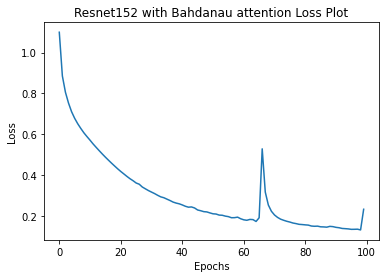

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Resnet152 with Bahdanau attention Loss Plot')
plt.show()

# save model locally

In [ ]:
!zip -r checkpoints_resnet.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/train/ (stored 0%)
  adding: checkpoints/train/ckpt-20.data-00000-of-00001 (deflated 10%)
  adding: checkpoints/train/ckpt-20.index (deflated 69%)
  adding: checkpoints/train/ckpt-17.index (deflated 69%)
  adding: checkpoints/train/checkpoint (deflated 71%)
  adding: checkpoints/train/ckpt-18.index (deflated 69%)
  adding: checkpoints/train/ckpt-18.data-00000-of-00001 (deflated 10%)
  adding: checkpoints/train/ckpt-19.data-00000-of-00001 (deflated 10%)
  adding: checkpoints/train/ckpt-19.index (deflated 69%)
  adding: checkpoints/train/ckpt-17.data-00000-of-00001 (deflated 10%)
  adding: checkpoints/train/ckpt-16.index (deflated 69%)
  adding: checkpoints/train/ckpt-16.data-00000-of-00001 (deflated 11%)


In [ ]:
from google.colab import files
files.download("checkpoints_resnet.zip")

#files.download(checkpoint_path + "/checkpoint")
#files.download(checkpoint_path + "/ckpt-1.data-00000-of-00001")
#files.download(checkpoint_path + "/ckpt-1.index")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#!zip -r open_images_data.zip OID

In [ ]:
#files.download("open_images_data.zip")

In [ ]:
print(ckpt_manager.checkpoints)

['./checkpoints/train/ckpt-16', './checkpoints/train/ckpt-17', './checkpoints/train/ckpt-18', './checkpoints/train/ckpt-19', './checkpoints/train/ckpt-20']


# load model (testing)

In [ ]:
encoder2 = CNN_Encoder(embedding_dim)
decoder2 = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())
checkpoint_path = "/content/checkpoints/train/ckpt-20" #.index"
ckpt = tf.train.Checkpoint(encoder=encoder2,
                           decoder=decoder2,
                           optimizer=optimizer)
model = ckpt.restore(checkpoint_path)


In [ ]:
!unzip /checkpoints.zip

unzip:  cannot find or open /checkpoints.zip, /checkpoints.zip.zip or /checkpoints.zip.ZIP.


In [ ]:
# def evaluate2(image):
#     attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = decoder.reset_state(batch_size=1)

#     temp_input = tf.expand_dims(load_image(image)[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
#                                                  -1,
#                                                  img_tensor_val.shape[3]))
#     #print(img_tensor_val.shape)
#     features = encoder2(img_tensor_val)

#     dec_input = tf.expand_dims([word_to_index('<start>')], 0)
#     result = []

#     for i in range(max_length):
#         predictions, hidden, attention_weights = decoder2(dec_input,
#                                                          features,
#                                                          hidden)

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

#         predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
#         #print(predictions.shape)
#         #predicted_id = tf.math.argmax(predictions,axis=1)[0].numpy()
#         #print("test:",predicted_id)
#         predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
#         result.append(predicted_word)

#         if predicted_word == '<end>':
#             return result, attention_plot

#         dec_input = tf.expand_dims([predicted_id], 0)

#     attention_plot = attention_plot[:len(result), :]
#     return result, attention_plot

In [ ]:
# # captions on the validation set
# rid = 0 #np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate2(image)

# print('Real Caption:', real_caption)
# print('Prediction Caption:', ' '.join(result))

# evaluation

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    #print(img_tensor_val.shape)
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #print(predictions.shape)
        #predicted_id = tf.math.argmax(predictions,axis=1)[0].numpy()
        #print("test:",predicted_id)
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> planes parked on a lot with loading gear near by. <end>
Prediction Caption: a man standing next to its doorway. <end>


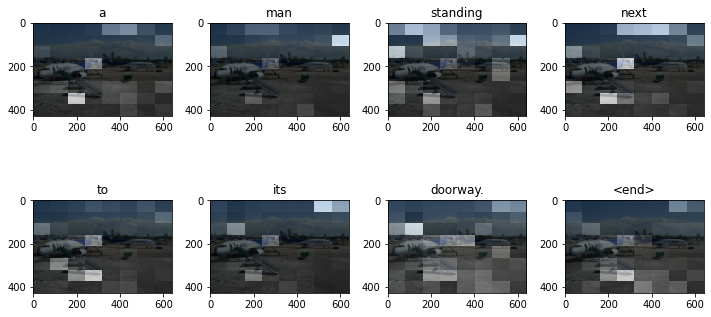

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
# #bleu-1
# sum_score = 0
# for idx in range(len(img_name_val)):
#   image = img_name_val[idx]
#   real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[idx] if i not in [0]])
#   result_caption, attention_plot = evaluate(image)
#   score = sentence_bleu(real_caption,result_caption, weights=(1, 0, 0, 0))
#   #print(real_caption,":::",result_caption)
#   sum_score += score

# sum_score = sum_score/(len(img_name_val))
# print(sum_score)

# evaluation no caps (save file to send to server) (dont need to worry about the h5 files)

In [ ]:
!wget https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json

--2022-04-26 21:14:52--  https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.88.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.88.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1101959 (1.1M) [application/json]
Saving to: ‘nocaps_val_image_info.json.2’

nocaps_val_image_in 100%[===================>]   1.05M  3.33MB/s    in 0.3s    

2022-04-26 21:14:53 (3.33 MB/s) - ‘nocaps_val_image_info.json.2’ saved [1101959/1101959]



In [ ]:
!cp -r /content/drive/MyDrive/validation_images_data.zip validation_images_data.zip

In [ ]:
!unzip validation_images_data.zip

Archive:  validation_images_data.zip
   creating: image_folder/
  inflating: image_folder/134125cb6e64c943.jpg  
  inflating: image_folder/020c23f7e78ed8fa.jpg  
  inflating: image_folder/e47734b6ece6fb9c.jpg  
  inflating: image_folder/67e89bcc0dc88204.jpg  
  inflating: image_folder/62693d8625abb7f3.jpg  
  inflating: image_folder/acd8371d50566145.jpg  
  inflating: image_folder/898a4921ab9f4cce.jpg  
  inflating: image_folder/90ed7d97a19c3666.jpg  
  inflating: image_folder/6bd300d5eef039b5.jpg  
  inflating: image_folder/920cdf2d9f5a8b82.jpg  
  inflating: image_folder/e825ec29627d3091.jpg  
  inflating: image_folder/92c4c71c141773b1.jpg  
  inflating: image_folder/2772a4a9283e46fc.jpg  
  inflating: image_folder/ccd1baf21b64d13a.jpg  
  inflating: image_folder/d6686aeee94c1def.jpg  
  inflating: image_folder/3f1b06ad13105fda.jpg  
  inflating: image_folder/a71021cbcb420dc2.jpg  
  inflating: image_folder/89692f83a1c95938.jpg  
  inflating: image_folder/59aeea2e6faef44f.jpg  
  inf

In [ ]:
import json
file_name = 'nocaps_val_image_info.json'
with open(file_name, 'r') as f:
  data = json.load(f)

links = []
for element in data["images"]:
  links.append(element['coco_url'])

In [ ]:
data["images"][0]

{'coco_url': 'https://s3.amazonaws.com/nocaps/val/0013ea2087020901.jpg',
 'date_captured': '2018-11-06 11:04:33',
 'file_name': '0013ea2087020901.jpg',
 'height': 1024,
 'id': 0,
 'license': 0,
 'open_images_id': '0013ea2087020901',
 'width': 732}

In [ ]:
import urllib
# captions on the no-caps validation set
results = []
for image_data in data["images"]:
  image_id = image_data["id"]
  file_name = image_data["file_name"] 
  caption, attention_plot = evaluate("image_folder/" + file_name)
  #image_id = os.path.splitext(os.path.basename(image_link))[0]
  caption_str = " ".join(caption)
  result_object = {"image_id": image_id, "caption": caption_str}
  results.append(result_object)
  #print(result_object)

with open("result_captions_resnet.json", "w") as f:
  json.dump(results,f)
# my_df = pd.DataFrame(results)
# my_df.to_csv('results_test.csv', index=False, header=False)

#note optimize this as its too long


In [ ]:
from google.colab import files
files.download("result_captions_resnet.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ////////////////////////////////////

# old

## get coco data

In [ ]:
# # Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                            cache_subdir=os.path.abspath('.'),
#                                            origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                            extract=True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
#   os.remove(annotation_zip)

# # Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin='http://images.cocodataset.org/zips/train2014.zip',
#                                       extract=True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

In [ ]:
# if os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_file = 'annotations/captions_train2014.json'

In [ ]:
# with open(annotation_file, 'r') as f:
#     annotations = json.load(f)

In [ ]:
# # Group all captions together having the same image ID.
# coco_image_path_to_caption = collections.defaultdict(list)
# for val in annotations['annotations']:
#   caption = f"<start> {val['caption']} <end>"
#   image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
#   coco_image_path_to_caption[image_path].append(caption)

In [ ]:
# image_paths = list(coco_image_path_to_caption.keys())
# random.shuffle(image_paths)

# # select first 3000 images
# coco_train_image_paths = image_paths[:3000]
# print(len(coco_train_image_paths))

In [ ]:
# print(coco_train_image_paths[0])

In [ ]:
# coco_train_captions = []
# coco_img_name_vector = []

# for image_path in coco_train_image_paths:
#   caption_list = coco_image_path_to_caption[image_path]
#   coco_train_captions.extend(caption_list)
#   coco_img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
# print(coco_train_captions[0])
# Image.open(coco_img_name_vector[0])

# get open images data

In [ ]:
# # get open images validation and test captions
# !wget https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json
# !wget https://s3.amazonaws.com/nocaps/nocaps_test_image_info.json

In [ ]:
# # open json
# import json
# validation_open_images = "nocaps_val_image_info.json"
# test_open_images = "nocaps_test_image_info.json"
# f1 = open(validation_open_images)
# validation_open_images = json.load(f1)
# f1.close()

# f2 = open(test_open_images)
# test_open_images = json.load(f2)
# f2.close()

In [ ]:
# # Download required meta-files
# # get anotations
# !wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
 
# !wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
 
# !wget https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv
 
# !wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv

In [ ]:
# !pip install awscli

In [ ]:
# # getting python script from drive because runtime removes files
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# # Download Sink and Toilet images for train
# !python3 "gdrive/MyDrive/open_images_load.py" --classes "Sink,Toilet" --mode train

In [ ]:
# # open csv file
# csv_file_dict = "class-descriptions-boxable.csv"
# labels = pd.read_csv(csv_file_dict, names=["LabelName","Label"], header=None)
# #print(labels.head())

# csv_file_boxes = "train-annotations-bbox.csv"
# boxes = pd.read_csv(csv_file_boxes)
# #print(boxes.head())

In [ ]:
# boxes.head()

In [ ]:
#data = boxes.merge(labels, on='LabelName', how='inner')

In [ ]:
# # get image ids
# import glob
# import os
# my_path = "train/"
# files = glob.glob(my_path + '/**/*.jpg', recursive=True)
# filenames = [os.path.splitext(os.path.basename(file))[0] for file in files]
# filenames[0:10]

In [ ]:
# # for image ids filter images in dataframe
# data_filtered = data[data['ImageID'].isin(filenames)]

In [ ]:
# imageids = data_filtered['ImageID'].unique()
# len(imageids)
# dictionary = {}
# for id in imageids:
#   subset = data[data['ImageID'].isin([id])]
#   labels_list = list(subset["Label"])
#   labels_list.append("<end>")
#   labels_list.insert(0,"<start>")
#   labels_str = " ".join(labels_list)
#   dictionary[id] = labels_str

In [ ]:
#dictionary

In [ ]:
# test = data_filtered[data_filtered['ImageID'].isin(["0b36b9c564f70e75"])]
# test.head()

In [ ]:
# data_filtered.head()

In [ ]:
# print(len(data_filtered))
# data_filtered['Label'].value_counts()

In [ ]:
# x = 10
# data_filtered[x:x+20]


In [ ]:
# data['Label'].value_counts()

In [ ]:
# dir = "train/Toilet/004d733b210847f8.jpg"
# image = Image.open(dir)
# image

get the openimages data

In [ ]:
# !aws s3 --no-sign-request cp s3://open-images-dataset/tar/train_e.tar.gz [target_dir]

## combine the two data sets

In [ ]:
# # get captions
# #open_images_object_string = list(dictionary.values())
# data_train_captions = coco_train_captions #+ open_images_object_string

In [ ]:
open_images_object_string

In [ ]:
# # get images
# open_image_img_name_vector = []
# for image_path in files:
#   open_image_img_name_vector.extend([image_path])

# data_train_images = coco_train_image_paths + open_image_img_name_vector

In [ ]:
# coco_train_image_paths[0]

In [ ]:
# open_image_img_name_vector[0]

# baseline model

In [ ]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.io.decode_jpeg(img, channels=3)
#     img = tf.keras.layers.Resizing(299, 299)(img)
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     return img, image_path

In [ ]:
# test = image_model = tf.keras.applications.InceptionV3(include_top=True,
#                                                 weights='imagenet')
# test.summary()

In [ ]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# image_model.output, image_features_extract_model.output

In [ ]:
#image_model.summary()

In [ ]:
# image_model.layers[-1], image_features_extract_model.layers[-1]

In [ ]:
#image_features_extract_model.summary()

In [ ]:
# # Get unique images
# encode_train = sorted(set(data_train_images))

# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# for img, path in image_dataset:
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [ ]:
# caption_dataset = tf.data.Dataset.from_tensor_slices(data_train_captions)

# # We will override the default standardization of TextVectorization to preserve
# # "<>" characters, so we preserve the tokens for the <start> and <end>.
# def standardize(inputs):
#   inputs = tf.strings.lower(inputs)
#   return tf.strings.regex_replace(inputs,
#                                   r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# # Max word count for a caption.
# max_length = 50
# # Use the top 5000 words for a vocabulary.
# vocabulary_size = 5000
# tokenizer = tf.keras.layers.TextVectorization(
#     max_tokens=vocabulary_size,
#     standardize=standardize,
#     output_sequence_length=max_length)
# # Learn the vocabulary from the caption data.
# tokenizer.adapt(caption_dataset)

In [ ]:
# # for element in caption_dataset:
# #   print(element)
# print(tokenizer)

In [ ]:
# # Create the tokenized vectors
# cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# # Create mappings for words to indices and indicies to words.
# word_to_index = tf.keras.layers.StringLookup(
#     mask_token="",
#     vocabulary=tokenizer.get_vocabulary())
# index_to_word = tf.keras.layers.StringLookup(
#     mask_token="",
#     vocabulary=tokenizer.get_vocabulary(),
#     invert=True)

In [ ]:
# img_to_cap_vector = collections.defaultdict(list)
# for img, cap in zip(data_train_images, cap_vector):
#   img_to_cap_vector[img].append(cap)

# # Create training and validation sets using an 80-20 split randomly.
# img_keys = list(img_to_cap_vector.keys())
# random.shuffle(img_keys)

# slice_index = int(len(img_keys)*0.8)
# img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

# img_name_train = []
# cap_train = []
# for imgt in img_name_train_keys:
#   capt_len = len(img_to_cap_vector[imgt])
#   img_name_train.extend([imgt] * capt_len)
#   cap_train.extend(img_to_cap_vector[imgt])

# img_name_val = []
# cap_val = []
# for imgv in img_name_val_keys:
#   capv_len = len(img_to_cap_vector[imgv])
#   img_name_val.extend([imgv] * capv_len)
#   cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
# print(cap_train[0].shape)

In [ ]:
# print(cap_train[0])

In [ ]:
# len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

In [ ]:
# # Feel free to change these parameters according to your system's configuration

# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# embedding_dim = 256
# units = 512
# num_steps = len(img_name_train) // BATCH_SIZE
# # Shape of the vector extracted from InceptionV3 is (64, 2048)
# # These two variables represent that vector shape
# features_shape = 2048
# attention_features_shape = 64

In [ ]:
# # Load the numpy files
# def map_func(img_name, cap):
#   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
#   return img_tensor, cap

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# # Use map to load the numpy files in parallel
# dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#           map_func, [item1, item2], [tf.float32, tf.int64]),
#           num_parallel_calls=tf.data.AUTOTUNE)

# # Shuffle and batch
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## model

In [ ]:
# class BahdanauAttention(tf.keras.Model):
#   def __init__(self, units):
#     super(BahdanauAttention, self).__init__()
#     self.W1 = tf.keras.layers.Dense(units)
#     self.W2 = tf.keras.layers.Dense(units)
#     self.V = tf.keras.layers.Dense(1)

#   def call(self, features, hidden):
#     # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

#     # hidden shape == (batch_size, hidden_size)
#     # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
#     hidden_with_time_axis = tf.expand_dims(hidden, 1)

#     # attention_hidden_layer shape == (batch_size, 64, units)
#     attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
#                                          self.W2(hidden_with_time_axis)))
#     print("attention_hidden_layer dim: ", attention_hidden_layer.shape)
#     # score shape == (batch_size, 64, 1)
#     # This gives you an unnormalized score for each image feature.
#     score = self.V(attention_hidden_layer)
#     print("score dim:", score.shape)
#     # attention_weights shape == (batch_size, 64, 1)
#     attention_weights = tf.nn.softmax(score, axis=1)

#     # context_vector shape after sum == (batch_size, hidden_size)
#     context_vector = attention_weights * features
#     context_vector = tf.reduce_sum(context_vector, axis=1)
#     print("context_vector dim:", context_vector.shape)
#     return context_vector, attention_weights

In [ ]:
# class CNN_Encoder(tf.keras.Model):
#     # Since you have already extracted the features and dumped it
#     # This encoder passes those features through a Fully connected layer
#     def __init__(self, embedding_dim):
#         super(CNN_Encoder, self).__init__()
#         # shape after fc == (batch_size, 64, embedding_dim)
#         self.fc = tf.keras.layers.Dense(embedding_dim)

#     def call(self, x):
#         x = self.fc(x)
#         x = tf.nn.relu(x)
#         print("encode fc dim:", x)

#         return x

In [ ]:
# class RNN_Decoder(tf.keras.Model):
#   def __init__(self, embedding_dim, units, vocab_size):
#     super(RNN_Decoder, self).__init__()
#     self.units = units

#     self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = tf.keras.layers.GRU(self.units,
#                                    return_sequences=True,
#                                    return_state=True,
#                                    recurrent_initializer='glorot_uniform')
#     self.fc1 = tf.keras.layers.Dense(self.units)
#     self.fc2 = tf.keras.layers.Dense(vocab_size)

#     self.attention = BahdanauAttention(self.units)

#   def call(self, x, features, hidden):
#     print("input dim x, features, hidden:", x.shape, features.shape, hidden.shape)
#     # defining attention as a separate model
#     context_vector, attention_weights = self.attention(features, hidden)

#     # x shape after passing through embedding == (batch_size, 1, embedding_dim)
#     x = self.embedding(x)
#     print("embedding dim:", x)

#     # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
#     x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
#     print("concat dim:", x)

#     # passing the concatenated vector to the GRU
#     output, state = self.gru(x)
#     print("gru dim:", output)

#     # shape == (batch_size, max_length, hidden_size)
#     x = self.fc1(output)
#     print("decode fc1 dim:", x)

#     # x shape == (batch_size * max_length, hidden_size)
#     x = tf.reshape(x, (-1, x.shape[2]))

#     # output shape == (batch_size * max_length, vocab)
#     x = self.fc2(x)
#     print("decode fc2 dim:", x)


#     return x, state, attention_weights

#   def reset_state(self, batch_size):
#     return tf.zeros((batch_size, self.units))

In [ ]:
# encoder = CNN_Encoder(embedding_dim)
# decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
# optimizer = tf.keras.optimizers.Adam()
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#     from_logits=True, reduction='none')


# def loss_function(real, pred):
#   mask = tf.math.logical_not(tf.math.equal(real, 0))
#   loss_ = loss_object(real, pred)

#   mask = tf.cast(mask, dtype=loss_.dtype)
#   loss_ *= mask

#   return tf.reduce_mean(loss_)

In [ ]:
# checkpoint_path = "./checkpoints/train"
# ckpt = tf.train.Checkpoint(encoder=encoder,
#                            decoder=decoder,
#                            optimizer=optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)

## Train

In [ ]:
# # adding this in a separate cell because if you run the training cell
# # many times, the loss_plot array will be reset
# loss_plot = []

In [ ]:
# @tf.function
# def train_step(img_tensor, target):
#   loss = 0

#   # initializing the hidden state for each batch
#   # because the captions are not related from image to image
#   hidden = decoder.reset_state(batch_size=target.shape[0])
#   print("hidden shape: ", hidden.shape)
#   dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

#   with tf.GradientTape() as tape:
#       features = encoder(img_tensor)
#       print("features shape:",features.shape)


#       for i in range(1, target.shape[1]):
#           # passing the features through the decoder
#           predictions, hidden, _ = decoder(dec_input, features, hidden)

#           loss += loss_function(target[:, i], predictions)

#           # using teacher forcing
#           dec_input = tf.expand_dims(target[:, i], 1)

#   total_loss = (loss / int(target.shape[1]))

#   trainable_variables = encoder.trainable_variables + decoder.trainable_variables

#   gradients = tape.gradient(loss, trainable_variables)

#   optimizer.apply_gradients(zip(gradients, trainable_variables))

#   return loss, total_loss

In [ ]:
# EPOCHS = 1

# for epoch in range(start_epoch, EPOCHS):
#     start = time.time()
#     total_loss = 0

#     for (batch, (img_tensor, target)) in enumerate(dataset):
#         print("image shape, caption shape:",img_tensor.shape, target.shape)
#         batch_loss, t_loss = train_step(img_tensor, target)
#         print("--------------------------------")
#         total_loss += t_loss

#         if batch % 10 == 0:
#             average_batch_loss = batch_loss.numpy()/int(target.shape[1])
#             print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
#     # storing the epoch end loss value to plot later
#     loss_plot.append(total_loss / num_steps)

#     if epoch % 5 == 0:
#       ckpt_manager.save()

#     print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
#     print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
# plt.plot(loss_plot)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Plot')
# plt.show()

# evaluation

In [ ]:
# def evaluate(image):
#     attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = decoder.reset_state(batch_size=1)

#     temp_input = tf.expand_dims(load_image(image)[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
#                                                  -1,
#                                                  img_tensor_val.shape[3]))
#     #print(img_tensor_val.shape)
#     features = encoder(img_tensor_val)

#     dec_input = tf.expand_dims([word_to_index('<start>')], 0)
#     result = []

#     for i in range(max_length):
#         predictions, hidden, attention_weights = decoder(dec_input,
#                                                          features,
#                                                          hidden)

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

#         predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
#         predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
#         result.append(predicted_word)

#         if predicted_word == '<end>':
#             return result, attention_plot

#         dec_input = tf.expand_dims([predicted_id], 0)

#     attention_plot = attention_plot[:len(result), :]
#     return result, attention_plot

In [ ]:
# def plot_attention(image, result, attention_plot):
#     temp_image = np.array(Image.open(image))

#     fig = plt.figure(figsize=(10, 10))

#     len_result = len(result)
#     for i in range(len_result):
#         temp_att = np.resize(attention_plot[i], (8, 8))
#         grid_size = max(int(np.ceil(len_result/2)), 2)
#         ax = fig.add_subplot(grid_size, grid_size, i+1)
#         ax.set_title(result[i])
#         img = ax.imshow(temp_image)
#         ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

#     plt.tight_layout()
#     plt.show()

In [ ]:
# len(img_name_val)

In [ ]:
# # captions on the validation set
# rid = 0 #np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)

# print('Real Caption:', real_caption)
# print('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

In [ ]:
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

# result, attention_plot = evaluate(image_path)
# print('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# # opening the image
# Image.open(image_path)

In [ ]:
# # captions on the validation set
# rid = 0
# image = img_name_val[rid]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)

# print(img_name_val)
# print('Real Caption:', real_caption)
# print('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

## bleu score

In [ ]:
# idx =  0
# from nltk.translate.bleu_score import sentence_bleu
# image = img_name_val[idx]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                         for i in cap_val[idx] if i not in [0]])
# result, attention_plot = evaluate(image)
# result_caption = ' '.join(result)
# score = sentence_bleu(real_caption,result_caption, weights=(1, 0, 0, 0))
# print(img_name_val)
# print(real_caption,":::",result_caption)
# print(score)

# #result of caption not consistent.

In [ ]:
# #bleu-1
# sum_score = 0
# for idx in range(len(img_name_val)):
#   image = img_name_val[idx]
#   real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[idx] if i not in [0]])
#   result_caption, attention_plot = evaluate(image)
#   score = sentence_bleu(real_caption,result_caption, weights=(1, 0, 0, 0))
#   #print(real_caption,":::",result_caption)
#   sum_score += score

# sum_score = sum_score/(len(img_name_val))
# print(sum_score)

In [ ]:
# #bleu-2
# sum_score = 0
# for idx in range(len(img_name_val)):
#   image = img_name_val[idx]
#   real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[idx] if i not in [0]])
#   result_caption, attention_plot = evaluate(image)
#   score = sentence_bleu(real_caption,result_caption, weights=(0, 1, 0, 0))
#   sum_score += score

# sum_score = sum_score/(len(img_name_val))
# print(sum_score)

In [ ]:
# #bleu-3
# sum_score = 0
# for idx in range(len(img_name_val)):
#   image = img_name_val[idx]
#   real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[idx] if i not in [0]])
#   result_caption, attention_plot = evaluate(image)
#   score = sentence_bleu(real_caption,result_caption, weights=(0, 0, 1, 0))
#   sum_score += score

# sum_score = sum_score/(len(img_name_val))
# print(sum_score)

In [ ]:
# #bleu-4
# sum_score = 0
# for idx in range(len(img_name_val)):
#   image = img_name_val[idx]
#   real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[idx] if i not in [0]])
#   result_caption, attention_plot = evaluate(image)
#   score = sentence_bleu(real_caption,result_caption, weights=(0, 0, 0, 1))
#   sum_score += score

# sum_score = sum_score/(len(img_name_val))
# print(sum_score)